In [82]:
#import
import numpy as np
import pandas as pd
import sqlite3 as sq3
from sqlite3 import Error
import requests
import os
import matplotlib.pyplot as plt


Join the data from Part 1 with the data from Part 2 to create a new dataframe.

In [2]:
#importing the data from part 1 and 2
bike_data = pd.read_csv('bike_data.csv')
fsquare_data = pd.read_csv('foursquare_food.csv')
yelp_data = pd.read_csv('yelp_food.csv')

In [4]:
bike_data.head()

,name,empty_slots,free_bikes,latitude,longitude,total_bike
0,Grand Marché,7,8,46.829433,-71.244066,15
1,Parc Lockwell,10,9,46.806196,-71.226874,19
2,Musée national des beaux-arts,17,2,46.801457,-71.226205,19
3,Grand Théâtre,12,2,46.805593,-71.221479,14
4,Parc de l'Esplanade,15,0,46.810506,-71.210669,15


In [6]:
fsquare_data.head()

,name,country,locality,near_station
0,Brasserie a la Source Martinière,CA,Québec,Grand Marché
1,Chez Mai,CA,Québec,Grand Marché
2,Frite Alors,CA,Québec,Parc Lockwell
3,Chez Victor,CA,Québec,Parc Lockwell
4,Café Sirocco,CA,Québec,Parc Lockwell


In [8]:
yelp_data.head()

,name,country,city,review_count,rating,near_station
0,Casa Calzone,CA,Quebec City,24,5.0,Grand Marché
1,Chez Carlos Café,CA,Quebec City,6,5.0,Grand Marché
2,Resto la Mama Grilled Cheese,CA,Québec City,5,4.5,Grand Marché
3,Sous-Marins le Marinier,CA,Quebec City,3,5.0,Grand Marché
4,Nguyen,CA,Quebec City,2,5.0,Grand Marché


In [12]:
#joining the bike and yelp data
yelp_full_data = yelp_data.join(bike_data.set_index('name'), on='near_station')

In [ ]:
#visualizing the data
yelp_full_data

In [109]:
#extracting the data to a csv file
yelp_full_data.to_csv('yelp df.csv', index=False)

In [15]:
#joining the bike and foursquare data
fsquare_full_data = fsquare_data.join(bike_data.set_index('name'), on='near_station')

In [ ]:
#visualizing the data
fsquare_full_data

In [110]:
#extracting the data to a csv file
fsquare_full_data.to_csv('Fsquare df.csv', index=False)

Provide a visualization that you used as part of your EDA process. Explain the initial pattern or relationship you discoved through this visualization. 

In [113]:
#setting up numbers of bikes and number of nearby restaurants as variables of interest
nearby_resto = fsquare_full_data.groupby(by='near_station').count()['name'].sort_values()
bike_num = fsquare_full_data[['near_station','total_bike']].drop_duplicates(keep='first')

Text(0, 0.5, 'number of restaurant nearby')

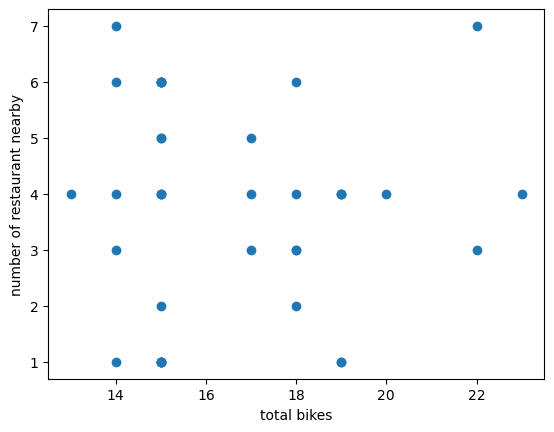

In [114]:
x = bike_num['total_bike']
y = nearby_resto

plt.scatter(x,y)
plt.xlabel('total bikes')
plt.ylabel('number of restaurant nearby')

Text(0, 0.5, 'review counts')

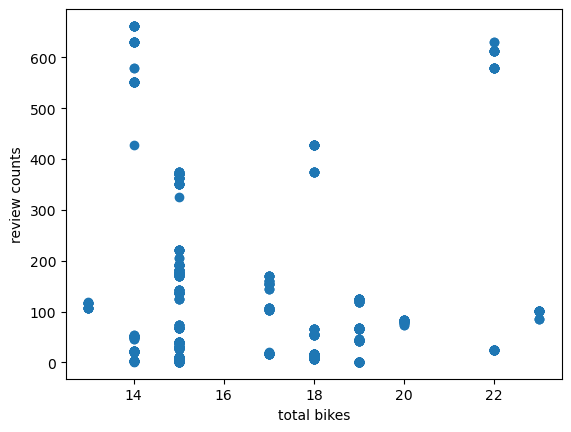

In [116]:
#relationship between number of bikes and review counts of restaurant nearby
review_num = yelp_full_data['review_count'].sort_values()

x = yelp_full_data['total_bike']
y = review_num

plt.scatter(x,y)
plt.xlabel('total bikes')
plt.ylabel('review counts')

Text(0, 0.5, 'ratings')

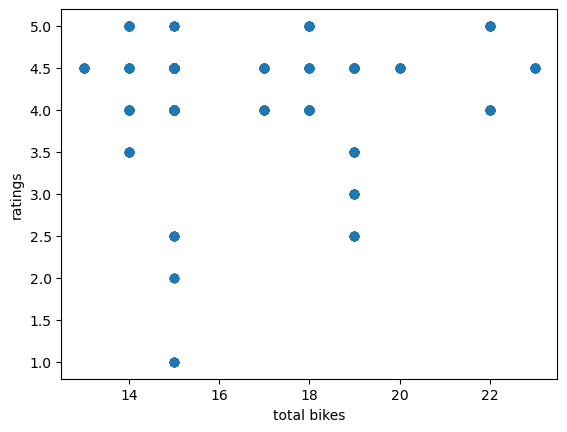

In [117]:
#Relationship between bike number and rating of restaurants nearby
rating = yelp_full_data['rating'].sort_values()

x = yelp_full_data['total_bike']
y = rating

plt.scatter(x,y)
plt.xlabel('total bikes')
plt.ylabel('ratings')

Text(0, 0.5, 'number of restaurants nearby')

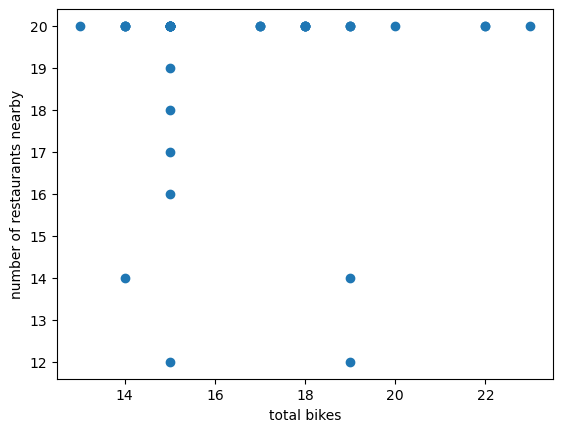

In [120]:
#Relationship between bike number and nearby restaurant from Yelp
yelp_nearby_resto = yelp_full_data.groupby(by='near_station').count()['name'].sort_values()
yelp_bike_num = yelp_full_data[['near_station','total_bike']].drop_duplicates(keep='first')

x = yelp_bike_num['total_bike']
y = yelp_nearby_resto

plt.scatter(x,y)
plt.xlabel('total bikes')
plt.ylabel('number of restaurants nearby')

# Database

Put all your results in an SQLite3 database (remember, SQLite stores its databases as files in your local machine - make sure to create your database in your project's data/ directory!)

In [85]:
#Function to create a connection to a database
def create_connection(path):
    connection = None
    try:
        connection = sq3.connect(path)
        print("Connection to SQLite DB successful")
    except Error as e:
        print(f"The error '{e}' occured")
    
    return connection

In [87]:
#connecting to the database(or creating one)
connection = create_connection('LHL_project2')

Connection to SQLite DB successful


In [83]:
#function to send a query as command to the database
def execute_query(connection, query):
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        connection.commit()
        print("Query executed successfully")
    except Error as e:
        print(f"The error '{e}' occurred")

In [88]:
#Creating the Yelp table inside the database
query = """CREATE TABLE IF NOT EXISTS yelp_search(
            name VARCHAR,
            country TEXT,
            city TEXT,
            review_count INT,
            rating FLOAT,
            near_station VARCHAR,
            empty_slots INT,
            free_bikes INT,
            latitude FLOAT,
            longitude FLOAT,
            total_bike INT)
"""
execute_query(connection,query)

Query executed successfully


In [107]:
#porting the values from the yelp dataframe into the table
yelp_full_data.to_sql('yelp_search', connection, if_exists='replace', index=False)

742

In [93]:
#function to execute queries
def execute_read_query(connection, query):
    cursor = connection.cursor()
    result = None
    try:
        cursor.execute(query)
        result = cursor.fetchall()
        return result
    except Error as e:
        print(f"The error '{e}' occurred")

In [108]:
#query to test if data is properly imported
query = 'SELECT * FROM yelp_search'
test = execute_read_query(connection, query)
for i in test[0:10]:
    print(i)

('Casa Calzone', 'CA', 'Quebec City', 24, 5.0, 'Grand Marché', 7, 8, 46.8294326924675, -71.24406570853023, 15)
('Chez Carlos Café', 'CA', 'Quebec City', 6, 5.0, 'Grand Marché', 7, 8, 46.8294326924675, -71.24406570853023, 15)
('Resto la Mama Grilled Cheese', 'CA', 'Québec City', 5, 4.5, 'Grand Marché', 7, 8, 46.8294326924675, -71.24406570853023, 15)
('Sous-Marins le Marinier', 'CA', 'Quebec City', 3, 5.0, 'Grand Marché', 7, 8, 46.8294326924675, -71.24406570853023, 15)
('Nguyen', 'CA', 'Quebec City', 2, 5.0, 'Grand Marché', 7, 8, 46.8294326924675, -71.24406570853023, 15)
('Brûlerie Limilou', 'CA', 'Quebec City', 2, 4.0, 'Grand Marché', 7, 8, 46.8294326924675, -71.24406570853023, 15)
('Mysa Sushi', 'CA', 'Quebec City', 2, 4.5, 'Grand Marché', 7, 8, 46.8294326924675, -71.24406570853023, 15)
('La Merveille du Vietnam', 'CA', 'Quebec City', 4, 3.0, 'Grand Marché', 7, 8, 46.8294326924675, -71.24406570853023, 15)
('Royal Tandori', 'CA', 'Quebec City', 3, 2.5, 'Grand Marché', 7, 8, 46.829432692

In [98]:
#Creating the foursquare table inside the database
query = """CREATE TABLE IF NOT EXISTS foursquare_search(
            name VARCHAR,
            country TEXT,
            city TEXT,
            near_station VARCHAR,
            empty_slots INT,
            free_bikes INT,
            latitude FLOAT,
            longitude FLOAT,
            total_bike INT)
"""
execute_query(connection, query)

Query executed successfully


In [103]:
#porting the values from the foursquare dataframe into the table
fsquare_full_data.to_sql('foursquare_search', connection, if_exists='replace', index=False)

146

In [119]:
#query to test if data is properly imported
query = 'SELECT * FROM foursquare_search'
test = execute_read_query(connection, query)
for i in test[0:10]:
    print(i)

('Brasserie a la Source Martinière', 'CA', 'Québec', 'Grand Marché', 7, 8, 46.8294326924675, -71.24406570853023, 15)
('Chez Mai', 'CA', 'Québec', 'Grand Marché', 7, 8, 46.8294326924675, -71.24406570853023, 15)
('Frite Alors', 'CA', 'Québec', 'Parc Lockwell', 10, 9, 46.80619619977287, -71.22687366229286, 19)
('Chez Victor', 'CA', 'Québec', 'Parc Lockwell', 10, 9, 46.80619619977287, -71.22687366229286, 19)
('Café Sirocco', 'CA', 'Québec', 'Parc Lockwell', 10, 9, 46.80619619977287, -71.22687366229286, 19)
('Sebz', 'CA', 'Québec', 'Parc Lockwell', 10, 9, 46.80619619977287, -71.22687366229286, 19)
('Bugel Fabrique de Bagels Enr', 'CA', 'Québec', 'Parc Lockwell', 10, 9, 46.80619619977287, -71.22687366229286, 19)
("Les Delices d'Ariana", 'CA', 'Québec', 'Parc Lockwell', 10, 9, 46.80619619977287, -71.22687366229286, 19)
('Restaurant Metropolitain', 'CA', 'Québec', 'Musée national des beaux-arts', 17, 2, 46.8014574117429, -71.22620529593462, 19)
('Bistro B', 'CA', 'Québec', 'Musée national des 

Look at the data before and after the join to validate your data.

In [111]:
yelp_full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742 entries, 0 to 741
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          742 non-null    object 
 1   country       742 non-null    object 
 2   city          742 non-null    object 
 3   review_count  742 non-null    int64  
 4   rating        742 non-null    float64
 5   near_station  742 non-null    object 
 6   empty_slots   742 non-null    int64  
 7   free_bikes    742 non-null    int64  
 8   latitude      742 non-null    float64
 9   longitude     742 non-null    float64
 10  total_bike    742 non-null    int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 63.9+ KB


In [112]:
fsquare_full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          146 non-null    object 
 1   country       146 non-null    object 
 2   locality      146 non-null    object 
 3   near_station  146 non-null    object 
 4   empty_slots   146 non-null    int64  
 5   free_bikes    146 non-null    int64  
 6   latitude      146 non-null    float64
 7   longitude     146 non-null    float64
 8   total_bike    146 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 10.4+ KB
